# Resample a DES cluster lensing chain with seven parameters

In this example, we will read in a DES Year 1 cluster weak lensing chain with six parameters ($\log_{10}M$,$c$,$\tau$,$f_{\rm mis}$,$A_M$,$B_0$,$R_s$) and build an importance sampler for it. We will then resample it and try to recover (essentially) the exact same chain.

"$\\Omega_m$": 0,"$h_0$": 1,"$\Omega_b h^2$": 2,"$\\log(10^{10} A_s)$": 3,"$n_s$": 4,"$\\Omega_\nu h^2$": 5,
       "s": 6,"q": 7,"$\\alpha$": 8,"$\\log M_{1}$": 9,"$\\log M_{min}$": 10, "$\\sigma_{intr}$": 11,"$\\sigma_8^{CDM+b}$": 12,"$\\sigma_8$": 13,"LnLike": 14

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.optimize as op
import corner #for making corner plots
import emcee #for doing MCMC
%matplotlib inline

In [2]:
plt.rc("font", size=18, family="serif")
#plt.rc("text", usetex=True)

In [3]:
#Read in the chain and remove burn-in (which I only know is there for this example)
input_chain = np.load("SDSS_ref_model.npy")
lnpost = input_chain[:,-1]
input_chain = input_chain[:,:12]
print("chain shape is  ", input_chain.shape)
print("lnpost shape is ", lnpost.shape)
print np.min(lnpost), np.max(lnpost)

('chain shape is  ', (422400, 12))
('lnpost shape is ', (422400,))
-9.9525143133 9.63024719644


In [4]:
#Pick out only 100 training points
N_training = 500
IS = isamp.ImportanceSampler(input_chain, lnpost, scale = 8)
IS.select_training_points(N_training, method="LH")

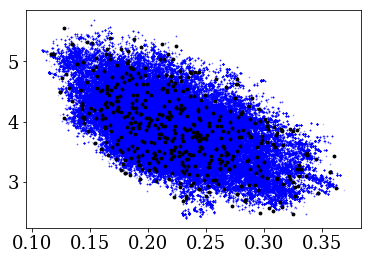

In [17]:
#Visualize the training points selected against the chain
fig, ax = plt.subplots(ncols=1, nrows=1)
plt.subplots_adjust(wspace=0.6)
ax.scatter(input_chain[:,0], input_chain[:,3], c='b', s=0.5, alpha=0.2)

points,_ = IS.get_training_data()
ax.scatter(points[:,0], points[:,3], c='k', s=8)

In [6]:
#Train the GP inside of the sampler
IS.train()

In [7]:
#Run an optimizer to see if we can recover the MLE
def neg_lnpost_predicted(p):
    return -IS.predict(p)
guess = input_chain[np.argmax(lnpost)]
result = op.minimize(neg_lnpost_predicted, guess, method="Nelder-Mead")
print(result)

 final_simplex: (array([[3.10505519e-01, 8.14487015e-01, 2.19356717e-02, 3.19340357e+00,
        1.04928703e+00, 2.85533139e-03, 3.77665160e-02, 1.01374034e+00,
        7.83201773e-01, 1.26348420e+01, 1.16280816e+01, 3.42117793e-01],
       [3.10578565e-01, 8.14407247e-01, 2.19352063e-02, 3.19347373e+00,
        1.04913597e+00, 2.85477086e-03, 3.77542551e-02, 1.01375092e+00,
        7.83241634e-01, 1.26347835e+01, 1.16279368e+01, 3.42066262e-01],
       [3.10495397e-01, 8.14566153e-01, 2.19353959e-02, 3.19316225e+00,
        1.04919545e+00, 2.85626923e-03, 3.77583982e-02, 1.01371551e+00,
        7.83182253e-01, 1.26348198e+01, 1.16279619e+01, 3.42478963e-01],
       [3.10499071e-01, 8.14439955e-01, 2.19334309e-02, 3.19314639e+00,
        1.04913683e+00, 2.85364186e-03, 3.77707834e-02, 1.01375552e+00,
        7.83226052e-01, 1.26346817e+01, 1.16281256e+01, 3.41876977e-01],
       [3.10514683e-01, 8.14461873e-01, 2.19360977e-02, 3.19319563e+00,
        1.04921059e+00, 2.85325798e-03, 3.7

In [8]:
nwalkers = 24
nd = len(input_chain[0])
pos = np.array([result.x + result.x*1e-3*np.random.randn(nd) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, nd, IS.predict)
_ = sampler.run_mcmc(pos, 1000)

In [9]:
test_chain = sampler.flatchain
print np.mean(input_chain, 0), np.std(input_chain, 0)
print np.mean(test_chain, 0), np.std(test_chain, 0)

[2.24272643e-01 7.41702150e-01 2.20237255e-02 3.89312575e+00
 9.72566141e-01 5.03424786e-03 3.76392011e-02 1.00881606e+00
 6.72830058e-01 1.24115353e+01 1.11690935e+01 3.35655009e-01] [4.69245535e-02 8.56673346e-02 5.09843798e-04 5.45128298e-01
 5.73677155e-02 2.62226583e-03 1.41382497e-02 1.99653619e-02
 5.89613652e-02 1.38623963e-01 2.00664926e-01 1.96748035e-01]
[3.00147854e-01 8.39127290e-01 2.17771435e-02 3.23123768e+00
 1.01879542e+00 4.90532473e-03 3.54456074e-02 1.01308283e+00
 7.88382018e-01 1.25968761e+01 1.14860983e+01 1.93118664e-01] [0.02173547 0.05362176 0.00043264 0.21227311 0.04111756 0.00238577
 0.00868359 0.01270323 0.02868472 0.05038576 0.13562189 0.16608615]


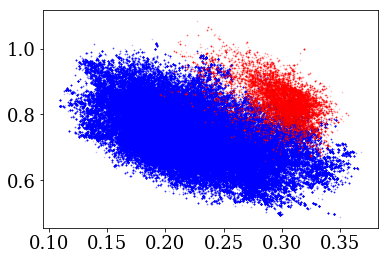

In [10]:
fig, ax = plt.subplots()
ax.scatter(input_chain[:,0], input_chain[:,1], c='b', s=0.5, alpha=0.2)
ax.scatter(test_chain[:,0], test_chain[:,1], c='r', s=0.5, alpha=0.2)

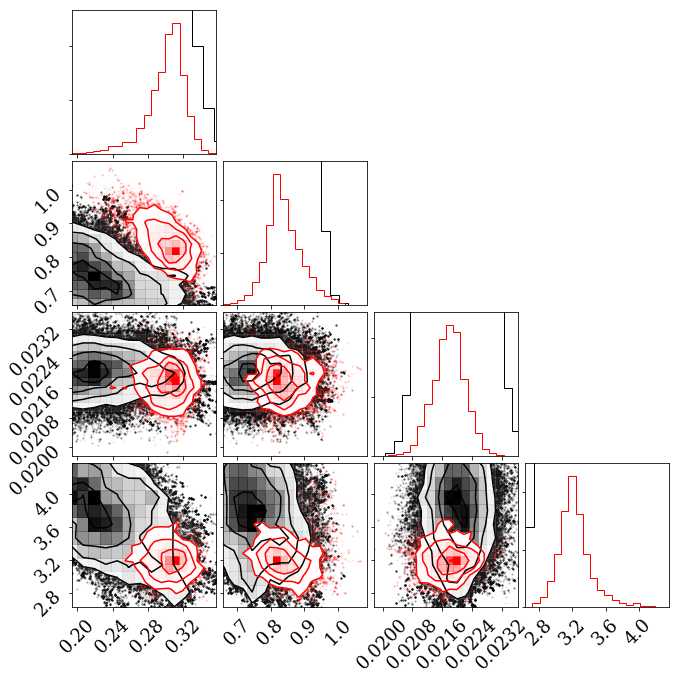

In [14]:
fig = corner.corner(input_chain[:,:4])
fig = corner.corner(test_chain[:,:4], fig=fig, color='r')
#fig.savefig("sevenD_test.png", dpi=300, bbox_inches="tight")